<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_7_5_Evo_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#@title Install Packages
!pip install livelossplot --quiet
!pip install deap --quiet

In [34]:
#@title Imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import math
import time
import random

import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras, PlotLosses
from IPython.display import clear_output

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

In [35]:
#@title Load Data
dataset = datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

# normalize and reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

x_train = x_train[:1000]
y_train= y_train[:1000]
x_test = x_test[:100]
y_test= y_test[:100]

In [36]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

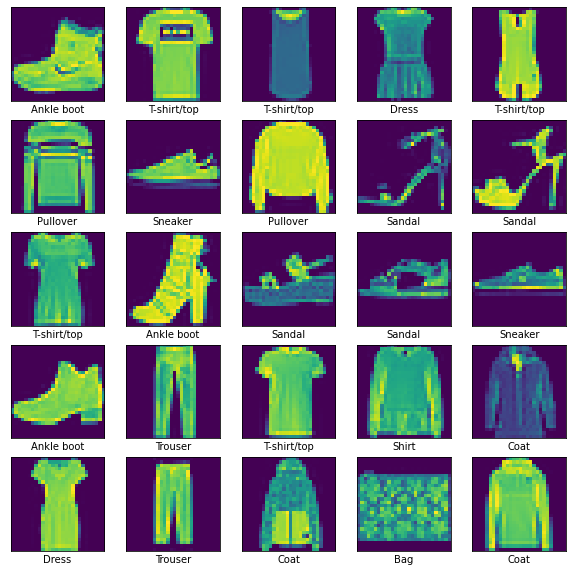

In [37]:
def plot_data(num_images, images, labels):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()

plot_data(25, x_train, y_train)

In [38]:
#@title Constants
max_layers = 5
max_neurons = 128
min_neurons = 16
max_kernel = 5
min_kernel = 2
max_pool = 3
min_pool = 2

CONV_LAYER = -1
CONV_LAYER_LEN = 4
POOLING_LAYER = -2
POOLING_LAYER_LEN = 3
BN_LAYER = -3
BN_LAYER_LEN = 1
DENSE_LAYER = -4
DENSE_LAYER_LEN = 2

In [39]:
#@title Encoding scheme
def generate_neurons():
  return random.randint(min_neurons, max_neurons)

def generate_kernel():
  part = []
  part.append(random.randint(min_kernel, max_kernel))
  part.append(random.randint(min_kernel, max_kernel))
  return part

def generate_bn_layer():
  part = [BN_LAYER] 
  return part

def generate_pooling_layer():
  part = [POOLING_LAYER] 
  part.append(random.randint(min_pool, max_pool))
  part.append(random.randint(min_pool, max_pool))
  return part

def generate_dense_layer():
  part = [DENSE_LAYER] 
  part.append(generate_neurons())  
  return part

def generate_conv_layer():
  part = [CONV_LAYER] 
  part.append(generate_neurons())
  part.extend(generate_kernel())
  return part

def create_offspring():
  ind = []
  for i in range(max_layers):
    if i==0: #first layer always convolutational
      ind.extend(generate_conv_layer())
    elif random.uniform(0,1)<.5:
      #add convolution layer
      ind.extend(generate_conv_layer())
      if random.uniform(0,1)<.5:
        #add batchnormalization
        ind.extend(generate_bn_layer())
      if random.uniform(0,1)<.5:
        #add max pooling layer
        ind.extend(generate_pooling_layer())
  ind.extend(generate_dense_layer())
  return ind
        
individual = create_offspring()
print(individual)


[-1, 96, 5, 5, -1, 107, 4, 3, -3, -2, 3, 2, -1, 97, 2, 4, -3, -2, 3, 3, -4, 76]


In [40]:
def build_model(individual):
  model = models.Sequential()
  il = len(individual)
  i = 0
  while i < il:
    if individual[i] == CONV_LAYER: 
      n = individual[i+1]
      k = (individual[i+2], individual[i+3])
      i += CONV_LAYER_LEN
      if i == 0: #first layer, add input shape      
        model.add(layers.Conv2D(n, k, activation='relu', padding="same", input_shape=(28, 28, 1)))      
      else:
        model.add(layers.Conv2D(n, k, activation='relu', padding="same"))    
    elif individual[i] == POOLING_LAYER: #add pooling layer
      k = k = (individual[i+1], individual[i+2])
      i += POOLING_LAYER_LEN
      model.add(layers.MaxPooling2D(k, padding="same"))      
    elif individual[i] == BN_LAYER: #add batchnormal layer
      model.add(layers.BatchNormalization())
      i += 1      
    elif individual[i] == DENSE_LAYER: #add dense layer
      model.add(layers.Flatten())      
      model.add(layers.Dense(individual[i+1], activation='relu'))
      i += 2
    else:
      break
  model.add(layers.Dense(10))
  return model

model = build_model(individual) 


In [41]:
def get_layers(ind, layer_type):
  return [a for a in range(len(ind)) if ind[a] == layer_type]

def swap(ind1, iv1, ind2, iv2, ll):
  ch1 = ind1[iv1:iv1+ll]
  ch2 = ind2[iv2:iv2+ll] 
  ind1[iv1:iv1+ll] = ch2
  ind2[iv2:iv2+ll] = ch1
  return ind1, ind2

def swap_layers(ind1, ind2, layer_type, layer_len):
  c1, c2 = get_layers(ind1, layer_type), get_layers(ind2, layer_type) 
  min_c = min(len(c1), len(c2))
  for i in range(min_c):
    if random.random() < 1:
      i1 = random.randint(0, len(c1)-1)
      i2 = random.randint(0, len(c2)-1)      
      iv1 = c1.pop(i1)
      iv2 = c2.pop(i2)    
      ind1, ind2 = swap(ind1, iv1, ind2, iv2, layer_len) 
  return ind1, ind2 

def crossover(ind1, ind2):  
  ind1, ind2 = swap_layers(ind1, ind2, CONV_LAYER, CONV_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, POOLING_LAYER, POOLING_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, BN_LAYER, BN_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, DENSE_LAYER, DENSE_LAYER_LEN)
  return ind1, ind2  

ind1 = create_offspring()
ind2 = create_offspring()
print(ind1)
print(ind2)

ind1, ind2 = crossover(ind1, ind2)
print(ind1)
print(ind2)

[-1, 64, 5, 5, -1, 78, 3, 5, -3, -2, 2, 3, -1, 87, 2, 4, -3, -2, 2, 2, -1, 22, 2, 3, -4, 82]
[-1, 34, 3, 4, -1, 55, 2, 5, -4, 128]
[-1, 55, 2, 5, -1, 78, 3, 5, -3, -2, 2, 3, -1, 34, 3, 4, -3, -2, 2, 2, -1, 22, 2, 3, -4, 128]
[-1, 87, 2, 4, -1, 64, 5, 5, -4, 82]


In [42]:
#@title Mutation
def mutate(part, layer_type):
  if layer_type == CONV_LAYER and len(part)==CONV_LAYER_LEN:
    part[1] = int(part[1] * random.uniform(.9, 1.1))
    part[2] = random.randint(min_kernel, max_kernel)
    part[3] = random.randint(min_kernel, max_kernel)
  elif layer_type == POOLING_LAYER and len(part)==POOLING_LAYER_LEN:
    part[1] = random.randint(min_kernel, max_kernel)
    part[2] = random.randint(min_kernel, max_kernel)
  elif layer_type == DENSE_LAYER and len(part)==DENSE_LAYER_LEN:
    part[1] = int(part[1] * random.uniform(.9, 1.1)) 
  else:
    error = f"mutate ERROR {part}"    
    raise Exception(error) 
  return part

def mutate_layers(ind, layer_type, layer_len):
  layers = get_layers(ind1, layer_type)
  for layer in layers:
    if random.random() < 1:
      try:
        ind[layer:layer+layer_len] = mutate(ind[layer:layer+layer_len], layer_type) 
      except:
        print(layers)
  return ind      

print(ind1)

def mutation(ind):  
  if len(ind) > CONV_LAYER_LEN: #only mutate conv individuals
    ind = mutate_layers(ind, CONV_LAYER, CONV_LAYER_LEN)
    ind = mutate_layers(ind, DENSE_LAYER, DENSE_LAYER_LEN)
    ind = mutate_layers(ind, POOLING_LAYER, POOLING_LAYER_LEN)
  return ind,

ind, = mutation(ind1)
print(ind)

[-1, 55, 2, 5, -1, 78, 3, 5, -3, -2, 2, 3, -1, 34, 3, 4, -3, -2, 2, 2, -1, 22, 2, 3, -4, 128]
[-1, 53, 3, 5, -1, 74, 5, 3, -3, -2, 2, 4, -1, 32, 2, 2, -3, -2, 2, 3, -1, 21, 2, 4, -4, 117]


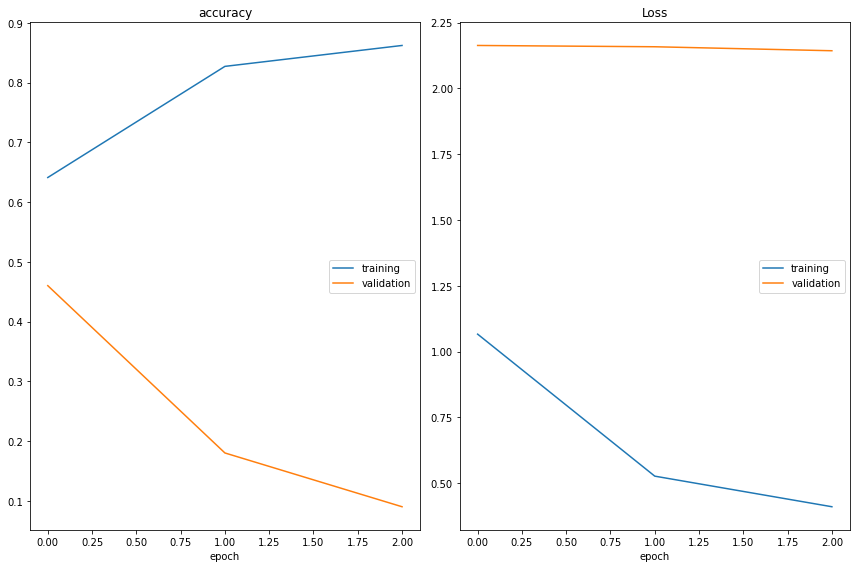

accuracy
	training         	 (min:    0.641, max:    0.862, cur:    0.862)
	validation       	 (min:    0.090, max:    0.460, cur:    0.090)
Loss
	training         	 (min:    0.411, max:    1.067, cur:    0.411)
	validation       	 (min:    2.143, max:    2.163, cur:    2.143)
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_397 (Conv2D)         (None, 28, 28, 53)        848       
                                                                 
 conv2d_398 (Conv2D)         (None, 28, 28, 74)        58904     
                                                                 
 batch_normalization_139 (Ba  (None, 28, 28, 74)       296       
 tchNormalization)                                               
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 14, 7, 74)        0         
 ng2D)                                

In [43]:
#@title Build, Compile and Train the model
def build_compile_train(ind, epochs=3):
  model = build_model(ind) 

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  history = model.fit(x_train, y_train, epochs=epochs, 
                      validation_data=(x_test, y_test),
                      callbacks=[PlotLossesKeras()],
                      verbose=0)

  model.summary()
  model.evaluate(x_test, y_test)

build_compile_train(ind)

Evolutionary CNN

In [44]:
#@title Setting up the Creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [45]:
#@title Create Individual and Population
toolbox = base.Toolbox()
toolbox.register("network", create_offspring)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.network)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [46]:
#@title Register Crossover and Mutation
toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)

In [47]:
#@title Register Evaluation
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def compile_train(model):
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  model.fit(x_train, y_train, epochs=3,                     
                    verbose=0)
  return model

def evaluate(individual):  
  try:
    model = build_model(individual)
    model = compile_train(model)
    print('.', end='')    
    return 1/clamp(model.evaluate(x_test, y_test, verbose=0)[1], .00001, 1),
  except:
    return 1/.5,  

toolbox.register("evaluate", evaluate)   

In [48]:
#@title Optimize the Weights { run: "auto" }
MU = 10 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 5 #@param {type:"slider", min:5, max:100, step:1}
RGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

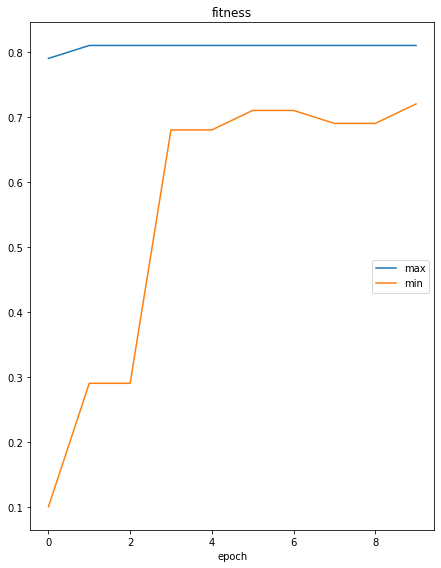

fitness
	max              	 (min:    0.790, max:    0.810, cur:    0.810)
	min              	 (min:    0.100, max:    0.720, cur:    0.720)


In [49]:
best = None
groups = { "fitness" : {"min", "max"}}
plotlosses = PlotLosses(groups=groups)

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 
  
  print(f"Gen ({(g+1)*RGEN})")      
  for l in logbook:
    plotlosses.update({'min': 1/l["max"], 'max': 1/l["min"]})
  plotlosses.send()  # draw, update logs, etc
   

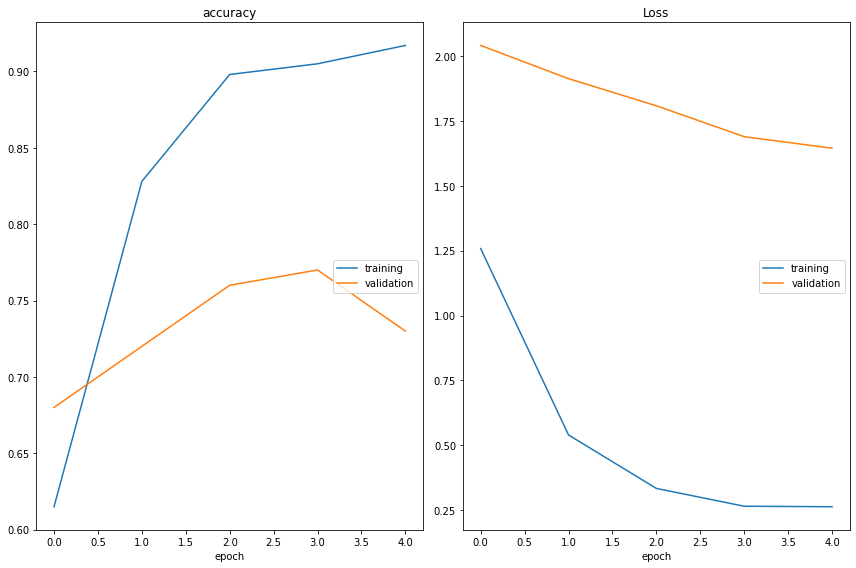

accuracy
	training         	 (min:    0.615, max:    0.917, cur:    0.917)
	validation       	 (min:    0.680, max:    0.770, cur:    0.730)
Loss
	training         	 (min:    0.263, max:    1.258, cur:    0.263)
	validation       	 (min:    1.645, max:    2.041, cur:    1.645)
Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_503 (Conv2D)         (None, 28, 28, 36)        468       
                                                                 
 conv2d_504 (Conv2D)         (None, 28, 28, 127)       41275     
                                                                 
 batch_normalization_184 (Ba  (None, 28, 28, 127)      508       
 tchNormalization)                                               
                                                                 
 max_pooling2d_195 (MaxPooli  (None, 10, 10, 127)      0         
 ng2D)                                

In [50]:
build_compile_train(best, epochs=5)